# Machine Learning - Cover Type Analysis
Group Assignment - **Section 1 Group D** - *Submitted: 27.03.2022*

![Tree](https://th.bing.com/th/id/R.d4a2dd941fa3470114e026a831ed07fe?rik=h04wIDYs9FQbyw&riu=http%3a%2f%2fwallpapercave.com%2fwp%2f9loeW9m.jpg&ehk=B2VFZfjBxfEfYESU8z35kUdl6JzkFHIumWq85kcs6pM%3d&risl=&pid=ImgRaw&r=0)

### Table of Contents:
1. Introduction
2. Exploratory Data Analysis
3. Data Cleaning
4. Feature Engineering
5. Feature Scaling
6. ML Predictive Analytics
7. Findings

## 1. Introduction
The task of this notebook is to predict the forest cover type (the predominant kind of tree cover) from strictly cartographic variables (as opposed to remotely sensed data). The actual forest cover type for a given 30 x 30 meter cell was determined from US Forest Service (USFS) Region 2 Resource Information System data. Independent variables were then derived from data obtained from the US Geological Survey and USFS. The data is in raw form (not scaled) and contains binary columns of data for qualitative independent variables such as wilderness areas and soil type.

This study area includes four wilderness areas located in the Roosevelt National Forest of northern Colorado. These areas represent forests with minimal human-caused disturbances, so that existing forest cover types are more a result of ecological processes rather than forest management practices.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.compose import (ColumnTransformer, make_column_transformer, make_column_selector)
from sklearn.pipeline import (Pipeline, make_pipeline)
from sklearn.preprocessing import (FunctionTransformer, OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler, PowerTransformer)
from sklearn.impute import (SimpleImputer, KNNImputer)
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,ExtraTreesClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, ShuffleSplit

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
seed = 49

In [4]:
df_train = pd.read_csv("../01 Data/train.csv")
df_test = pd.read_csv("../01 Data/test.csv")

---
## 2. Exploratory analysis

---
### 2.1 Shape of data

In [5]:
print(df_train.shape)

(15120, 56)


In [6]:
print(df_train.dtypes)

Id                                    int64
Elevation                             int64
Aspect                                int64
Slope                                 int64
Horizontal_Distance_To_Hydrology      int64
Vertical_Distance_To_Hydrology        int64
Horizontal_Distance_To_Roadways       int64
Hillshade_9am                         int64
Hillshade_Noon                        int64
Hillshade_3pm                         int64
Horizontal_Distance_To_Fire_Points    int64
Wilderness_Area1                      int64
Wilderness_Area2                      int64
Wilderness_Area3                      int64
Wilderness_Area4                      int64
Soil_Type1                            int64
Soil_Type2                            int64
Soil_Type3                            int64
Soil_Type4                            int64
Soil_Type5                            int64
Soil_Type6                            int64
Soil_Type7                            int64
Soil_Type8                      

In [7]:
pd.set_option('display.max_columns', None)
print(df_train.describe())

# No attribute is missing as count is 15120 for all attributes. Hence, all rows can be used
# Negative value(s) present in Vertical_Distance_To_Hydrology. Hence, some tests such as chi-sq cant be used.
# Wilderness_Area and Soil_Type are one hot encoded. Hence, they could be converted back for some analysis
# Attributes Soil_Type7 and Soil_Type15 can be removed as they are constant
# Scales are not the same for all. Hence, rescaling and standardization may be necessary for some algos

                Id     Elevation        Aspect         Slope  \
count  15120.00000  15120.000000  15120.000000  15120.000000   
mean    7560.50000   2749.322553    156.676653     16.501587   
std     4364.91237    417.678187    110.085801      8.453927   
min        1.00000   1863.000000      0.000000      0.000000   
25%     3780.75000   2376.000000     65.000000     10.000000   
50%     7560.50000   2752.000000    126.000000     15.000000   
75%    11340.25000   3104.000000    261.000000     22.000000   
max    15120.00000   3849.000000    360.000000     52.000000   

       Horizontal_Distance_To_Hydrology  Vertical_Distance_To_Hydrology  \
count                      15120.000000                    15120.000000   
mean                         227.195701                       51.076521   
std                          210.075296                       61.239406   
min                            0.000000                     -146.000000   
25%                           67.000000         

In [8]:
print(df_train.skew())
# Values close to 0 show less skew
# Several attributes in Soil_Type show a large skew

Id                                      0.000000
Elevation                               0.075640
Aspect                                  0.450935
Slope                                   0.523658
Horizontal_Distance_To_Hydrology        1.488052
Vertical_Distance_To_Hydrology          1.537776
Horizontal_Distance_To_Roadways         1.247811
Hillshade_9am                          -1.093681
Hillshade_Noon                         -0.953232
Hillshade_3pm                          -0.340827
Horizontal_Distance_To_Fire_Points      1.617099
Wilderness_Area1                        1.231244
Wilderness_Area2                        5.228781
Wilderness_Area3                        0.324594
Wilderness_Area4                        0.825798
Soil_Type1                              6.294716
Soil_Type2                              4.617019
Soil_Type3                              3.575995
Soil_Type4                              3.872721
Soil_Type5                              9.416209
Soil_Type6          

In [9]:
df_train.groupby('Cover_Type').size()
# No class re-balancing is necessary

Cover_Type
1    2160
2    2160
3    2160
4    2160
5    2160
6    2160
7    2160
dtype: int64

---
### 2.2 Correlation

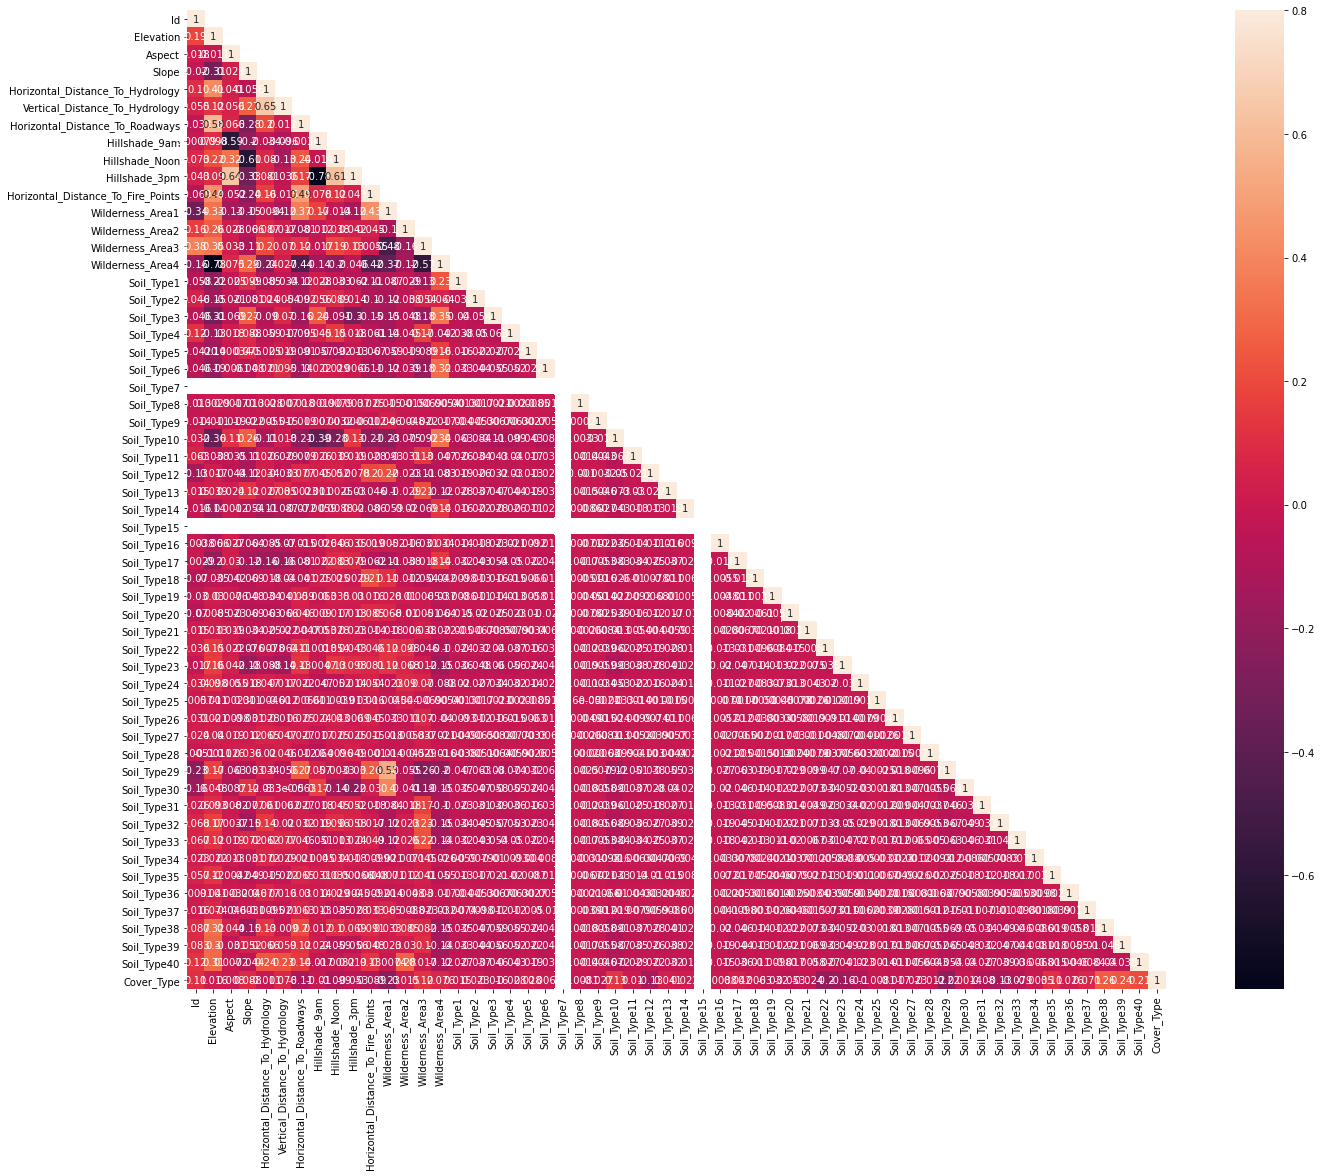

In [10]:
fig, ax = plt.subplots(figsize=(25,18))  
corrMatrix = df_train.corr()
mask=np.array(corrMatrix)
mask[np.tril_indices_from(mask)]=False
sns.heatmap(corrMatrix,mask=mask,vmax=0.8,square=True,annot=True,ax=ax)

plt.show()

In [11]:
#sets the number of features considered
size = 10 

#create a dataframe with only 'size' features
data_size=df_train.iloc[:,:size] 

#get the names of all the columns
cols=data_size.columns 

# Calculates pearson co-efficient for all combinations
data_corr = data_size.corr()

# Set the threshold to select only only highly correlated attributes
threshold = 0.5

# List of pairs along with correlation above threshold
corr_list = []

#Search for the highly correlated pairs
for i in range(0,size): #for 'size' features
    for j in range(i+1,size): #avoid repetition
        if (data_corr.iloc[i,j] >= threshold and data_corr.iloc[i,j] < 1) or (data_corr.iloc[i,j] < 0 and data_corr.iloc[i,j] <= -threshold):
            corr_list.append([data_corr.iloc[i,j],i,j]) #store correlation and columns index

#Sort to show higher ones first            
s_corr_list = sorted(corr_list,key=lambda x: -abs(x[0]))

#Print correlations and column names
for v,i,j in s_corr_list:
    print ("%s and %s = %.2f" % (cols[i],cols[j],v))

# Strong correlation is observed between the following pairs
# This represents an opportunity to reduce the feature set through transformations such as PCA

Hillshade_9am and Hillshade_3pm = -0.78
Horizontal_Distance_To_Hydrology and Vertical_Distance_To_Hydrology = 0.65
Aspect and Hillshade_3pm = 0.64
Hillshade_Noon and Hillshade_3pm = 0.61
Slope and Hillshade_Noon = -0.61
Aspect and Hillshade_9am = -0.59
Elevation and Horizontal_Distance_To_Roadways = 0.58


---
### 2.3 Visualizations

#### 2.3.1 Pairplots of correlated variables

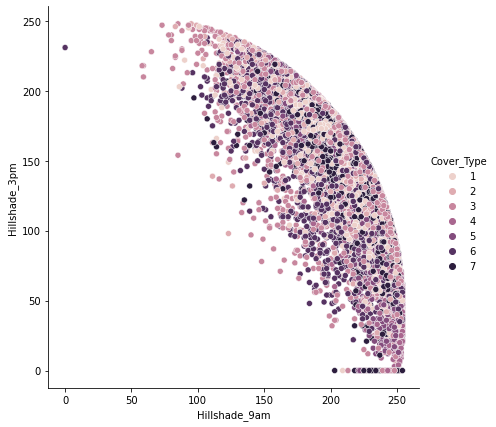

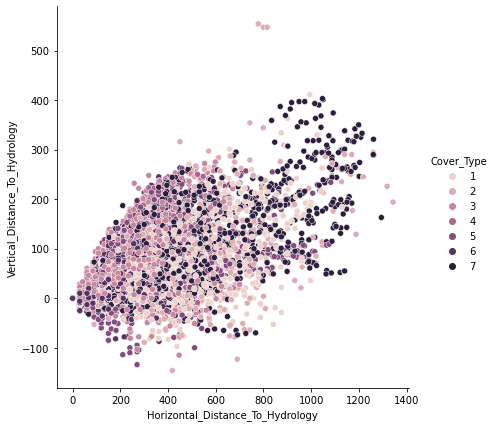

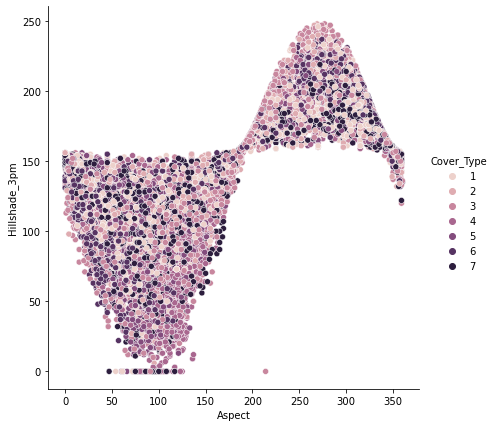

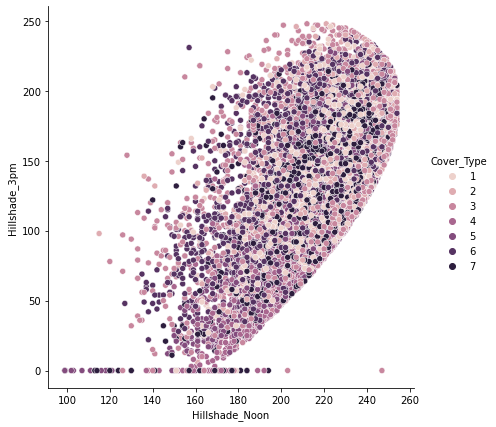

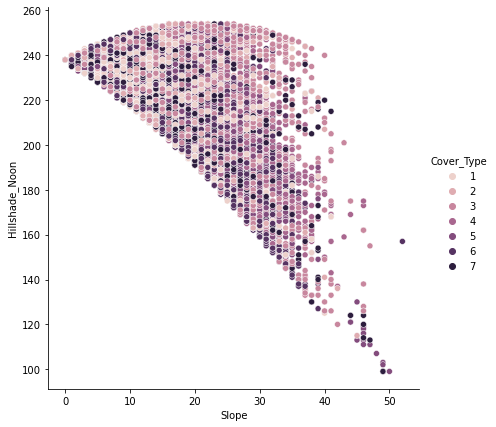

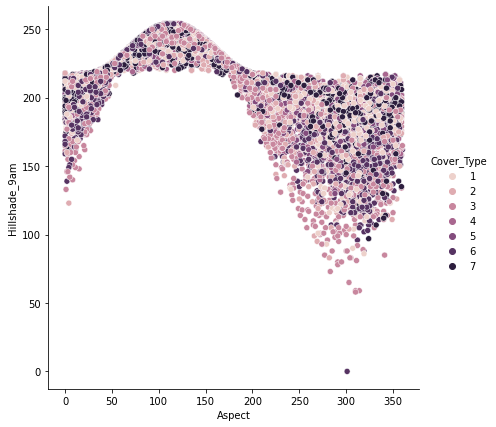

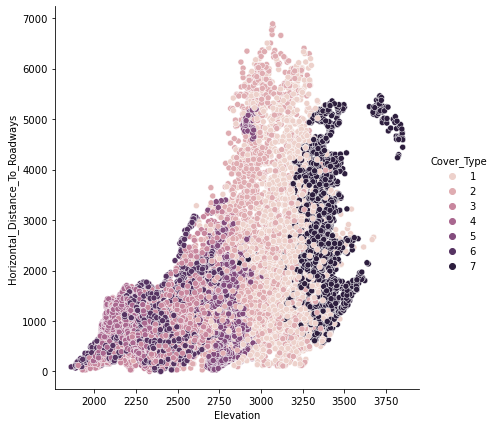

In [12]:
for v,i,j in s_corr_list:
    sns.pairplot(df_train, hue="Cover_Type", size=6, x_vars=cols[i],y_vars=cols[j] )
    plt.show()

#### 2.3.2 Violinplots of all features (excluding soil)

In [13]:
cols = df_train.columns
len(cols)

56

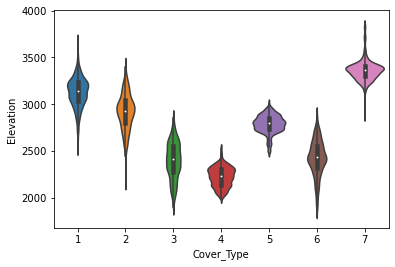

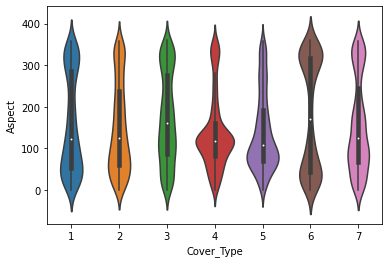

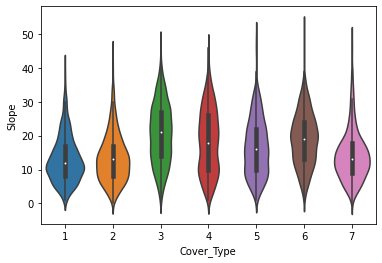

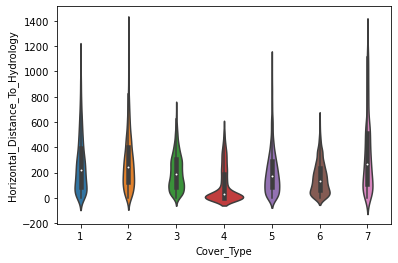

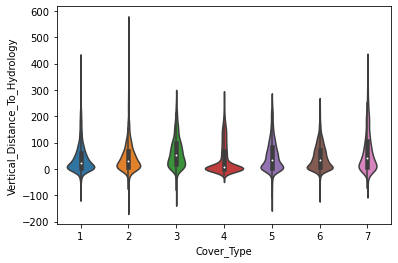

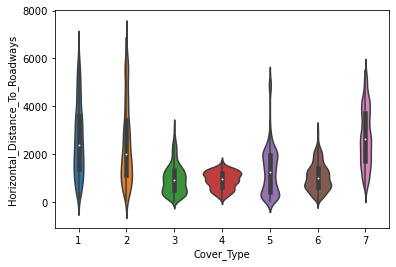

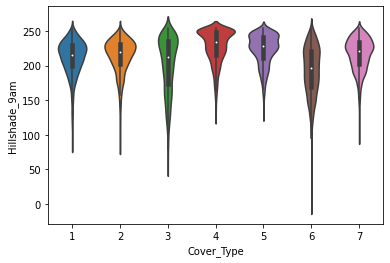

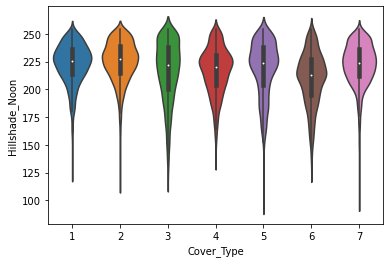

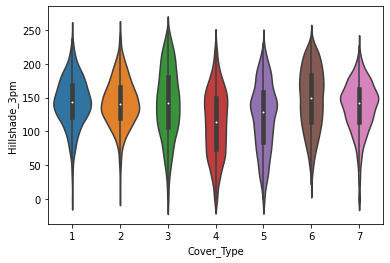

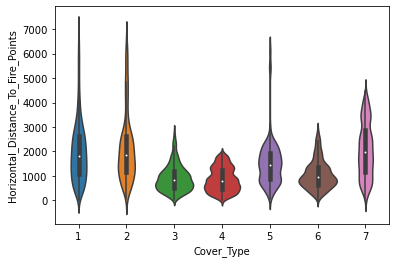

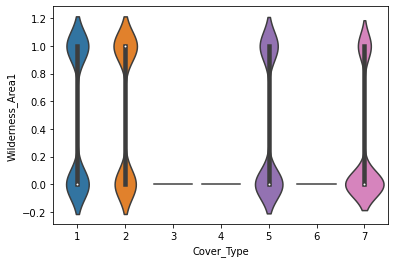

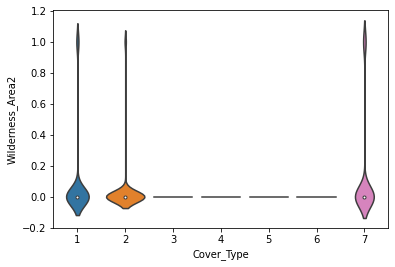

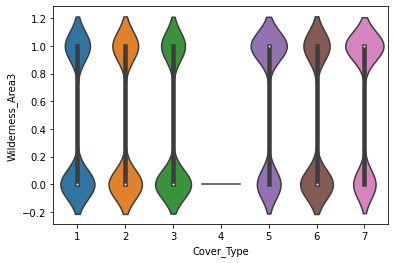

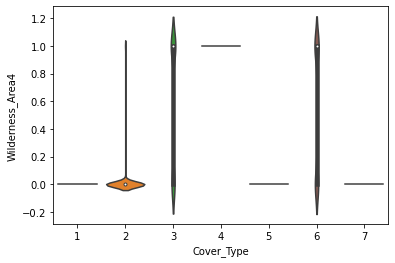

In [14]:
# We will visualize all the attributes using Violin Plot - a combination of box and density plots

#names of all the attributes 
cols = df_train.columns

#number of attributes (exclude target)
size = len(cols)-1

#x-axis has target attribute to distinguish between classes
x = cols[size]

#y-axis shows values of an attribute
y = cols[0:size]

#Plot violin for all attributes
for i in range(1,size-40):
    sns.violinplot(data=df_train,x=x,y=y[i])  
    plt.show()

#Elevation is has a separate distribution for most classes. Highly correlated with the target and hence an important attribute
#Aspect contains a couple of normal distribution for several classes
#Horizontal distance to road and hydrology have similar distribution
#Hillshade 9am and 12pm display left skew
#Hillshade 3pm is normal
#Lots of 0s in vertical distance to hydrology
#Wilderness_Area3 gives no class distinction. As values are not present, others gives some scope to distinguish
#Soil_Type, 1,5,8,9,12,14,18-22, 25-30 and 35-40 offer class distinction as values are not present for many classes

#### 2.3.2 Countplots for Wilderness_Area and Soil_Type distribution

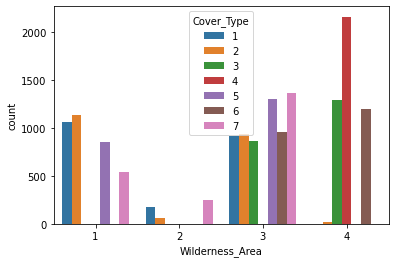

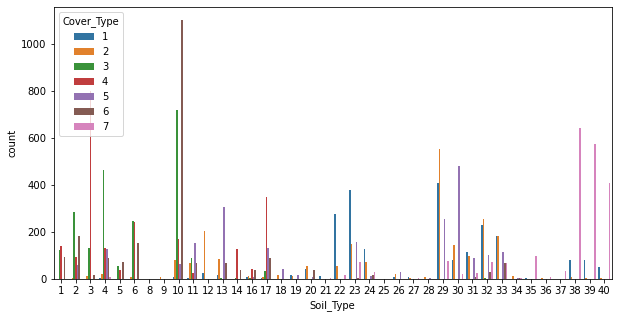

In [15]:
# Group one-hot encoded variables of a category into one single variable

df_train_2 = df_train.drop(["Id"], axis = 1)

#names of all the columns
cols = df_train_2.columns

#number of rows=r , number of columns=c
r,c = df_train_2.shape

#Create a new dataframe with r rows, one column for each encoded category, and target in the end
data_2 = pd.DataFrame(index=np.arange(0, r),columns=['Wilderness_Area','Soil_Type','Cover_Type'])

#Make an entry in 'data' for each r as category_id, target value
for i in range(0,r):
    w=0;
    s=0;
    # Category1 range
    for j in range(10,14):
        if (df_train_2.iloc[i,j] == 1):
            w=j-9  #category class
            break
    # Category2 range        
    for k in range(14,54):
        if (df_train_2.iloc[i,k] == 1):
            s=k-13 #category class
            break
    #Make an entry in 'data' for each r as category_id, target value        
    data_2.iloc[i]=[w,s,df_train_2.iloc[i,c-1]]

#Plot for Category1    
sns.countplot(x="Wilderness_Area", hue="Cover_Type", data=data_2)
plt.show()
#Plot for Category2
plt.rc("figure", figsize=(10, 5))
sns.countplot(x="Soil_Type", hue="Cover_Type", data=data_2)
plt.show()

#(right-click and open the image in a new window for larger size)
#WildernessArea_4 has a lot of presence for cover_type 4. Good class distinction
#WildernessArea_3 has not much class distinction
#SoilType 1-6,10-14,17, 22-23, 29-33,35,38-40 offer lot of class distinction as counts for some are very high

---
## 3. Data cleaning

---
### 3.1 Screening for missing values 

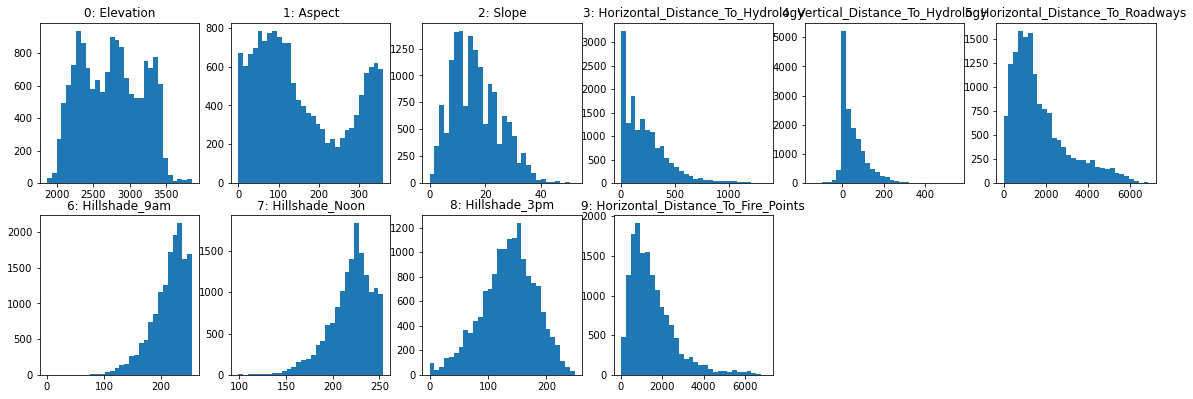

In [16]:
fig, axes = plt.subplots(3, 6, figsize=(20, 10))
for i, ax in enumerate(axes.ravel()):
    if i > 9:
        ax.set_visible(False)
        continue
    ax.hist(df_train.iloc[:, i+1], bins=30)
    ax.set_title("{}: {}".format(i, df_train.columns[i+1]))

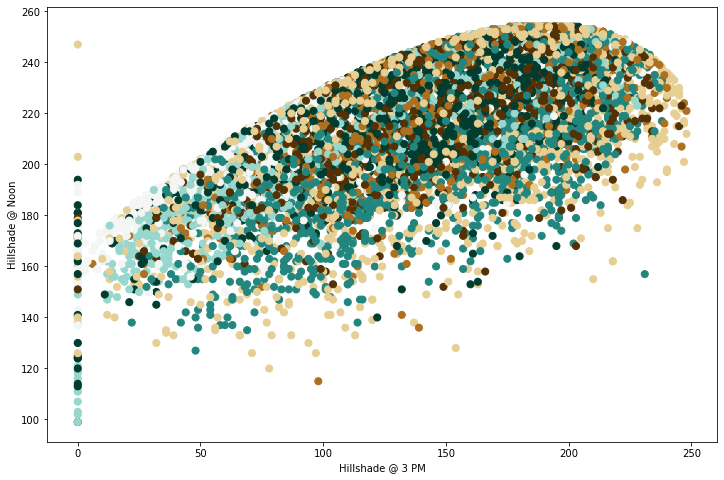

In [17]:
plt.figure(figsize=(12,8))
plt.scatter(df_train.Hillshade_3pm,df_train.Hillshade_Noon, c=df_train.Cover_Type, s=50, cmap=plt.cm.BrBG)
plt.xlabel('Hillshade @ 3 PM')
plt.ylabel('Hillshade @ Noon')
plt.show()

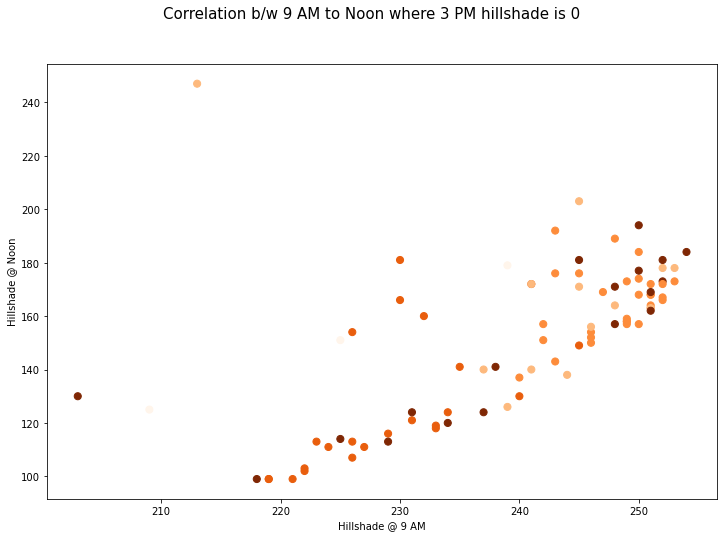

In [18]:
smaller_frame=df_train[df_train.Hillshade_3pm==0] 
plt.figure(figsize=(12,8))
plt.scatter(smaller_frame.Hillshade_9am,smaller_frame.Hillshade_Noon, c=smaller_frame.Cover_Type, s=50, cmap=plt.cm.Oranges)
plt.suptitle('Correlation b/w 9 AM to Noon where 3 PM hillshade is 0', fontsize=15)
plt.xlabel('Hillshade @ 9 AM')
plt.ylabel('Hillshade @ Noon')
plt.show()

---
### 3.2 Imputing missing values 

In [19]:
#Make a copy and Reorder train.csv columns
temp=df_train.copy()
cols=temp.columns.tolist()
cols=cols[:8]+cols[9:]+[cols[8]]
temp=temp[cols]

#Delete the Forest Cover Type column. We can't train on this since it doesn't exist in the test.csv file
del temp['Cover_Type']

In [20]:
#Split the train.csv file into train (available values) and missing values based on hillshade 3 PM.
X,y,X_df_train_missing,y_df_train_missing= temp[temp.Hillshade_3pm!=0].values[:,:-1],\
temp[temp.Hillshade_3pm!=0].values[:,-1:].ravel(),\
temp[temp.Hillshade_3pm==0].values[:,:-1],\
temp[temp.Hillshade_3pm==0].values[:,-1:].ravel() 

#Let's very quickly do a train/cv split so we can see how the model will generalize. Note that we're calling this cv since #we're not going to be doing exhaustive cross-validation. We'll test performance using the cv set and predict on test. I am #calling this cv so as to not confuse with terminology.
X_train,X_test,y_train,y_test=train_test_split(X,y)

In [21]:
gbrt=GradientBoostingRegressor(n_estimators=1000) 
gbrt.fit(X_train,y_train)

GradientBoostingRegressor(n_estimators=1000)

In [22]:
print ('Training R-squared value: %.2f' %gbrt.score(X_train, y_train))
print ('Test R-squared value: %.2f' %gbrt.score(X_test, y_test))

Training R-squared value: 1.00
Test R-squared value: 1.00


In [23]:
#Predict and fill missing values in train.csv
temp.Hillshade_3pm.loc[temp.Hillshade_3pm==0]=gbrt.predict(X_df_train_missing)
df_train.Hillshade_3pm=temp.Hillshade_3pm

In [24]:
#Make a copy and Reorder test.csv columns
temp=df_test.copy()
cols=temp.columns.tolist()
cols=cols[:8]+cols[9:]+[cols[8]]
temp=temp[cols]
#Extract missing rows from test.csv then predict and fill in the blanks.
X_df_test_missing= temp[temp.Hillshade_3pm==0].values[:,:-1]
temp.Hillshade_3pm.loc[temp.Hillshade_3pm==0]=gbrt.predict(X_df_test_missing)
df_test.Hillshade_3pm=temp.Hillshade_3pm

---
### 3.3 Validating new inputs 

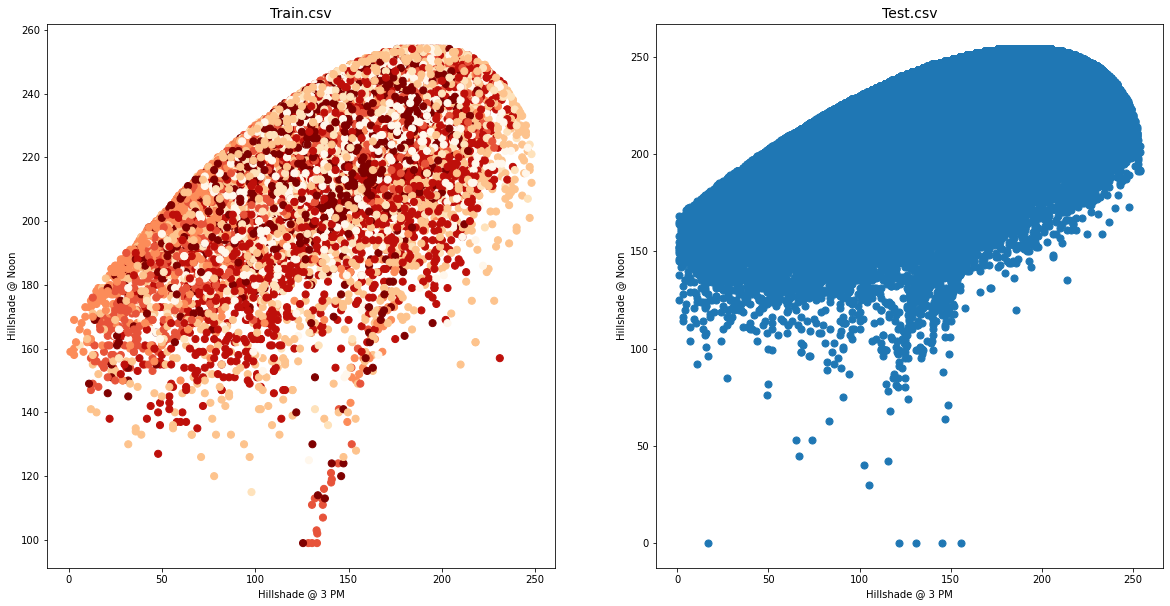

In [25]:
fig, ax=plt.subplots(1,2,figsize=(20,10)) 
ax[0].scatter(df_train.Hillshade_3pm,df_train.Hillshade_Noon, c=df_train.Cover_Type, s=50, cmap=plt.cm.OrRd)
ax[0].set_xlabel('Hillshade @ 3 PM')
ax[0].set_ylabel('Hillshade @ Noon')
ax[0].set_title('Train.csv', fontsize=14)
ax[1].scatter(df_test.Hillshade_3pm,df_test.Hillshade_Noon, s=50, cmap=plt.cm.PuBu)
ax[1].set_xlabel('Hillshade @ 3 PM')
ax[1].set_ylabel('Hillshade @ Noon')
ax[1].set_title('Test.csv', fontsize=14)
plt.show()

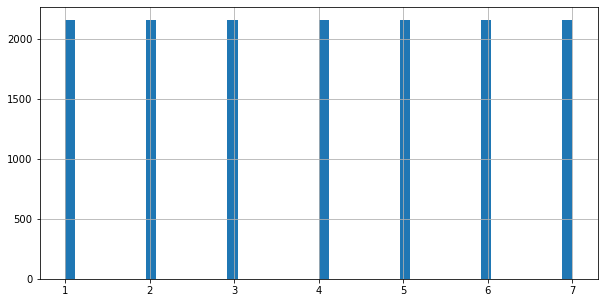

In [26]:
df_train.Cover_Type.hist(bins=50)
plt.show()

---
## 4. Feature Engineering

---
### 4.1 Define new features 

In [27]:
def add_feature(df_train):   
    df_train['Ele_minus_VDtHyd'] = df_train.Elevation-df_train.Vertical_Distance_To_Hydrology
    df_train['Ele_plus_VDtHyd'] = df_train.Elevation+df_train.Vertical_Distance_To_Hydrology
    df_train['Distance_to_Hydrolody'] = (df_train['Horizontal_Distance_To_Hydrology']**2+df_train['Vertical_Distance_To_Hydrology']**2)**0.5
    df_train['Hydro_plus_Fire'] = df_train['Horizontal_Distance_To_Hydrology']+df_train['Horizontal_Distance_To_Fire_Points']
    df_train['Hydro_minus_Fire'] = df_train['Horizontal_Distance_To_Hydrology']-df_train['Horizontal_Distance_To_Fire_Points']
    df_train['Hydro_plus_Road'] = df_train['Horizontal_Distance_To_Hydrology']+df_train['Horizontal_Distance_To_Roadways']
    df_train['Hydro_minus_Road'] = df_train['Horizontal_Distance_To_Hydrology']-df_train['Horizontal_Distance_To_Roadways']
    df_train['Fire_plus_Road'] = df_train['Horizontal_Distance_To_Fire_Points']+df_train['Horizontal_Distance_To_Roadways']
    df_train['Fire_minus_Road'] = df_train['Horizontal_Distance_To_Fire_Points']-df_train['Horizontal_Distance_To_Roadways']
    df_train['Elev_to_HD_Hyd']=df_train.Elevation - 0.2 * df_train.Horizontal_Distance_To_Hydrology 
    df_train['Elev_to_HD_Road']=df_train.Elevation - 0.05 * df_train.Horizontal_Distance_To_Roadways 
    df_train['Elev_to_VD_Hyd']=df_train.Elevation - df_train.Vertical_Distance_To_Hydrology 
    df_train['Mean_Amenities']=(df_train.Horizontal_Distance_To_Fire_Points + df_train.Horizontal_Distance_To_Hydrology + df_train.Horizontal_Distance_To_Roadways) / 3
    df_train['Mean_Fire_Hyd']=(df_train.Horizontal_Distance_To_Fire_Points + df_train.Horizontal_Distance_To_Hydrology) / 2 
    
    return df_train

---
### 4.2 Integrate features into dataset 

In [28]:
train = add_feature(df_train)
test = add_feature(df_test)

In [29]:
#Reorder train.csv columns
cols=train.columns.tolist()
cols=cols[:10]+cols[-14:]+cols[10:-14]
train=train[cols]

In [30]:
#Reorder test.csv columns 
cols=test.columns.tolist()
cols=cols[:10]+cols[-14:]+cols[10:-14]
test=test[cols]

---
## 5. Feature Scaling

---
### 5.1 Analyzing outliers 

In [31]:
def outlier_function(df, col_name):
    first_quartile = np.percentile(np.array(df[col_name].tolist()), 25)
    third_quartile = np.percentile(np.array(df[col_name].tolist()), 75)
    IQR = third_quartile - first_quartile
                      
    upper_limit = third_quartile+(3*IQR)
    lower_limit = first_quartile-(3*IQR)
    outlier_count = 0
                      
    for value in df[col_name].tolist():
        if (value < lower_limit) | (value > upper_limit):
            outlier_count +=1
    return lower_limit, upper_limit, outlier_count

In [32]:
df_train

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type,Ele_minus_VDtHyd,Ele_plus_VDtHyd,Distance_to_Hydrolody,Hydro_plus_Fire,Hydro_minus_Fire,Hydro_plus_Road,Hydro_minus_Road,Fire_plus_Road,Fire_minus_Road,Elev_to_HD_Hyd,Elev_to_HD_Road,Elev_to_VD_Hyd,Mean_Amenities,Mean_Fire_Hyd
0,1,2596,51,3,258,0,510,221,232,148.0,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5,2596,2596,258.000000,6537,-6021,768,-252,6789,5769,2544.4,2570.50,2596,2349.000000,3268.5
1,2,2590,56,2,212,-6,390,220,235,151.0,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5,2596,2584,212.084889,6437,-6013,602,-178,6615,5835,2547.6,2570.50,2596,2275.666667,3218.5
2,3,2804,139,9,268,65,3180,234,238,135.0,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2739,2869,275.769832,6389,-5853,3448,-2912,9301,2941,2750.4,2645.00,2739,3189.666667,3194.5
3,4,2785,155,18,242,118,3090,238,238,122.0,6211,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2667,2903,269.235956,6453,-5969,3332,-2848,9301,3121,2736.6,2630.50,2667,3181.000000,3226.5
4,5,2595,45,2,153,-1,391,220,234,150.0,6172,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5,2596,2594,153.003268,6325,-6019,544,-238,6563,5781,2564.4,2575.45,2596,2238.666667,3162.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15115,15116,2607,243,23,258,7,660,170,251,214.0,1282,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,2600,2614,258.094944,1540,-1024,918,-402,1942,622,2555.4,2574.00,2600,733.333333,770.0
15116,15117,2603,121,19,633,195,618,249,221,91.0,1325,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,2408,2798,662.354890,1958,-692,1251,15,1943,707,2476.4,2572.10,2408,858.666667,979.0
15117,15118,2492,134,25,365,117,335,250,220,83.0,1187,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,2375,2609,383.293621,1552,-822,700,30,1522,852,2419.0,2475.25,2375,629.000000,776.0
15118,15119,2487,167,28,218,101,242,229,237,119.0,932,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,2386,2588,240.260276,1150,-714,460,-24,1174,690,2443.4,2474.90,2386,464.000000,575.0


In [76]:
for i in df_train.columns[:11]:
    if outlier_function(df_train, i)[2] > 0:
        print("There are {} outliers in {}".format(outlier_function(df_train, i)[2], i))

There are 53 outliers in Horizontal_Distance_To_Hydrology
There are 49 outliers in Vertical_Distance_To_Hydrology
There are 3 outliers in Horizontal_Distance_To_Roadways
There are 7 outliers in Hillshade_9am
There are 20 outliers in Hillshade_Noon
There are 132 outliers in Horizontal_Distance_To_Fire_Points


---
### 5.2 Scaling features

#### 5.2.1 Feature overview without scaling

Without scaling some features show highly skewed histograms and outliers. 

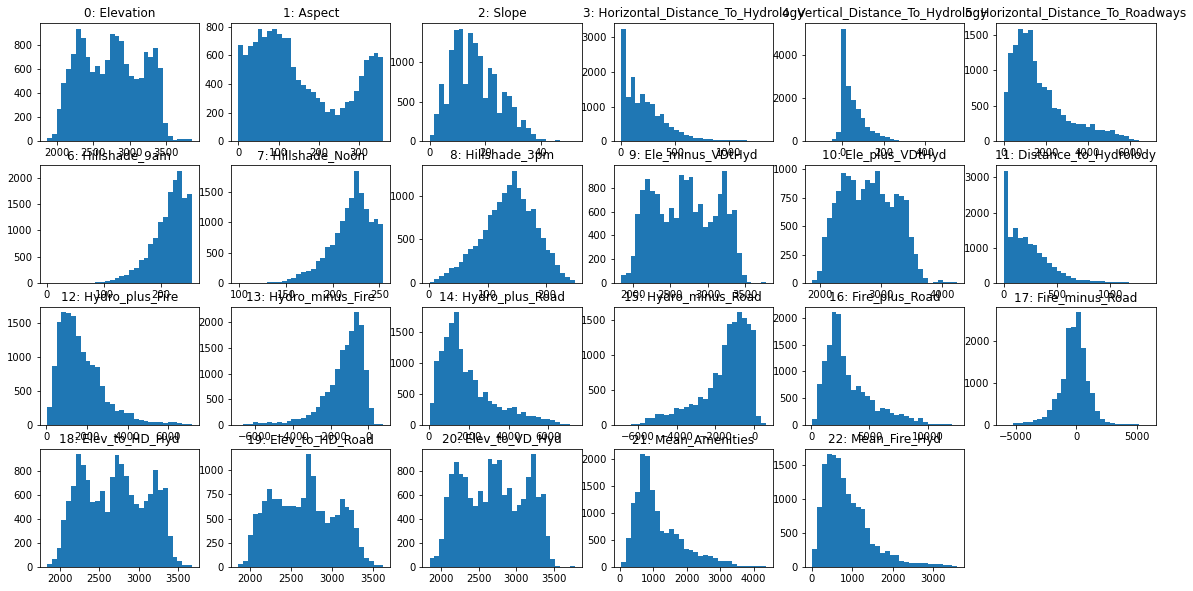

In [34]:
fig, axes = plt.subplots(4, 6, figsize=(20, 10))
for i, ax in enumerate(axes.ravel()):
    if i > 22:
        ax.set_visible(False)
        continue
    ax.hist(train.iloc[:, i+1], bins=30)
    ax.set_title("{}: {}".format(i, train.columns[i+1]))

<AxesSubplot:>

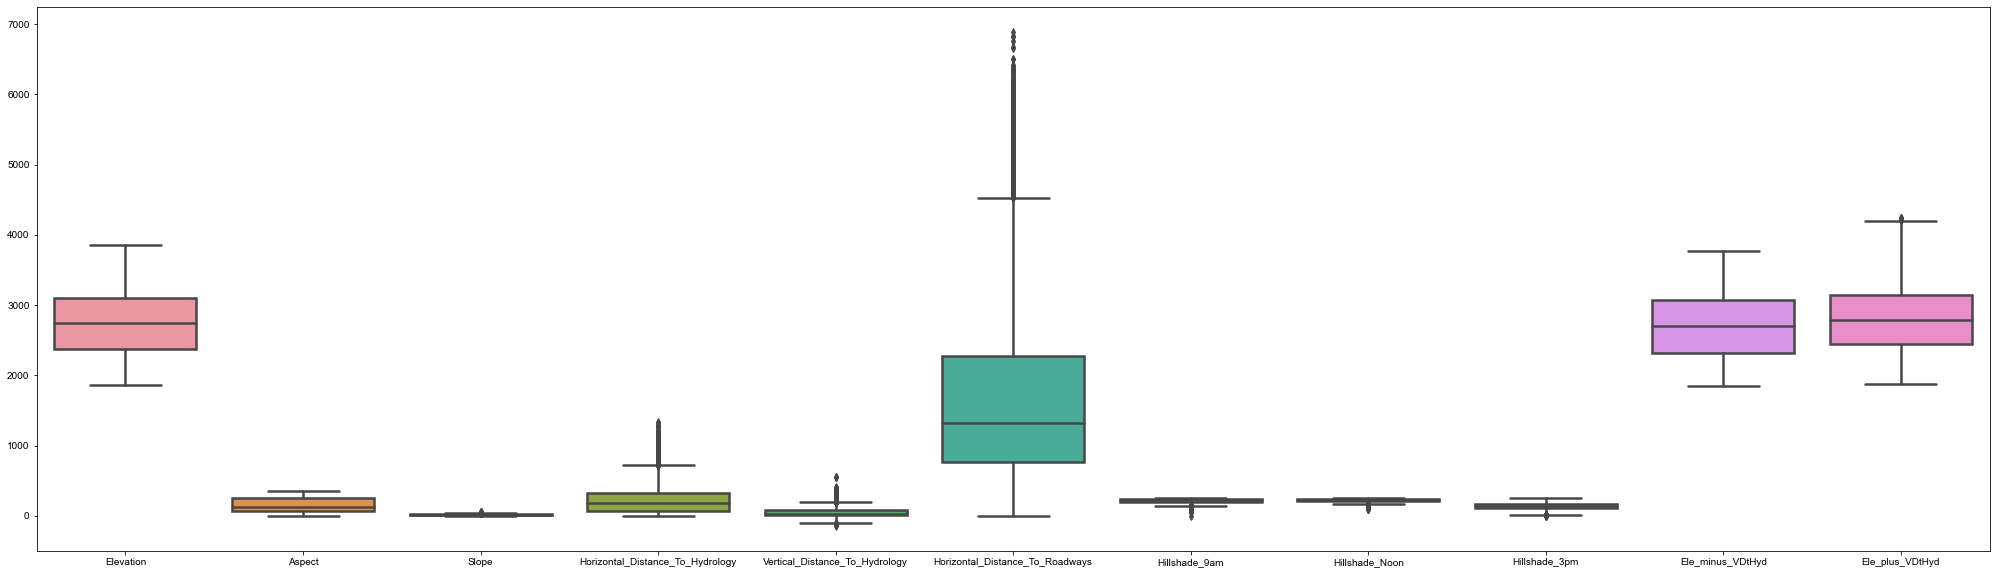

In [35]:
fig, axes = plt.subplots(1, figsize=(35, 10))
sns.set(style='whitegrid')
sns.boxplot(data=pd.DataFrame(data = train).iloc[:,1:12],linewidth=2.5)

#### 5.2.2 Feature overview with scaling

In [36]:
MMscaler = MinMaxScaler()
SSscaler = StandardScaler()
train_scaled = MMscaler.fit_transform(train.iloc[:,1:62])
test_scaled = MMscaler.fit_transform(test.iloc[:,1:62])

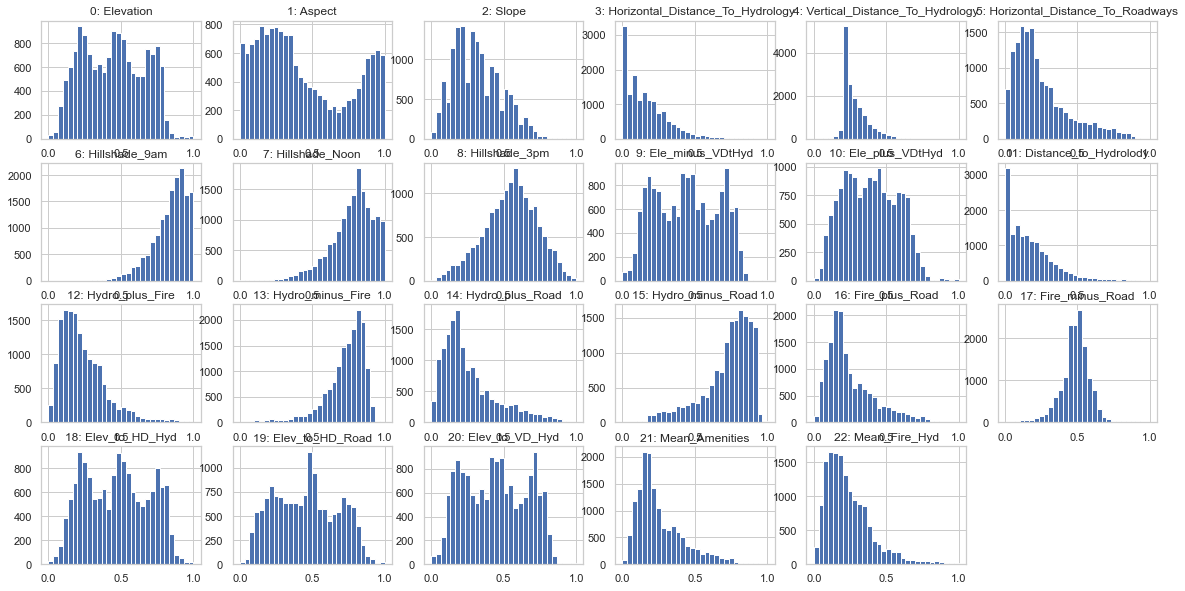

In [37]:
fig, axes = plt.subplots(4, 6, figsize=(20, 10))
for i, ax in enumerate(axes.ravel()):
    if i > 22:
        ax.set_visible(False)
        continue
    ax.hist(train_scaled[:, i], bins=30)
    ax.set_title("{}: {}".format(i, train.columns[i+1]))

<AxesSubplot:>

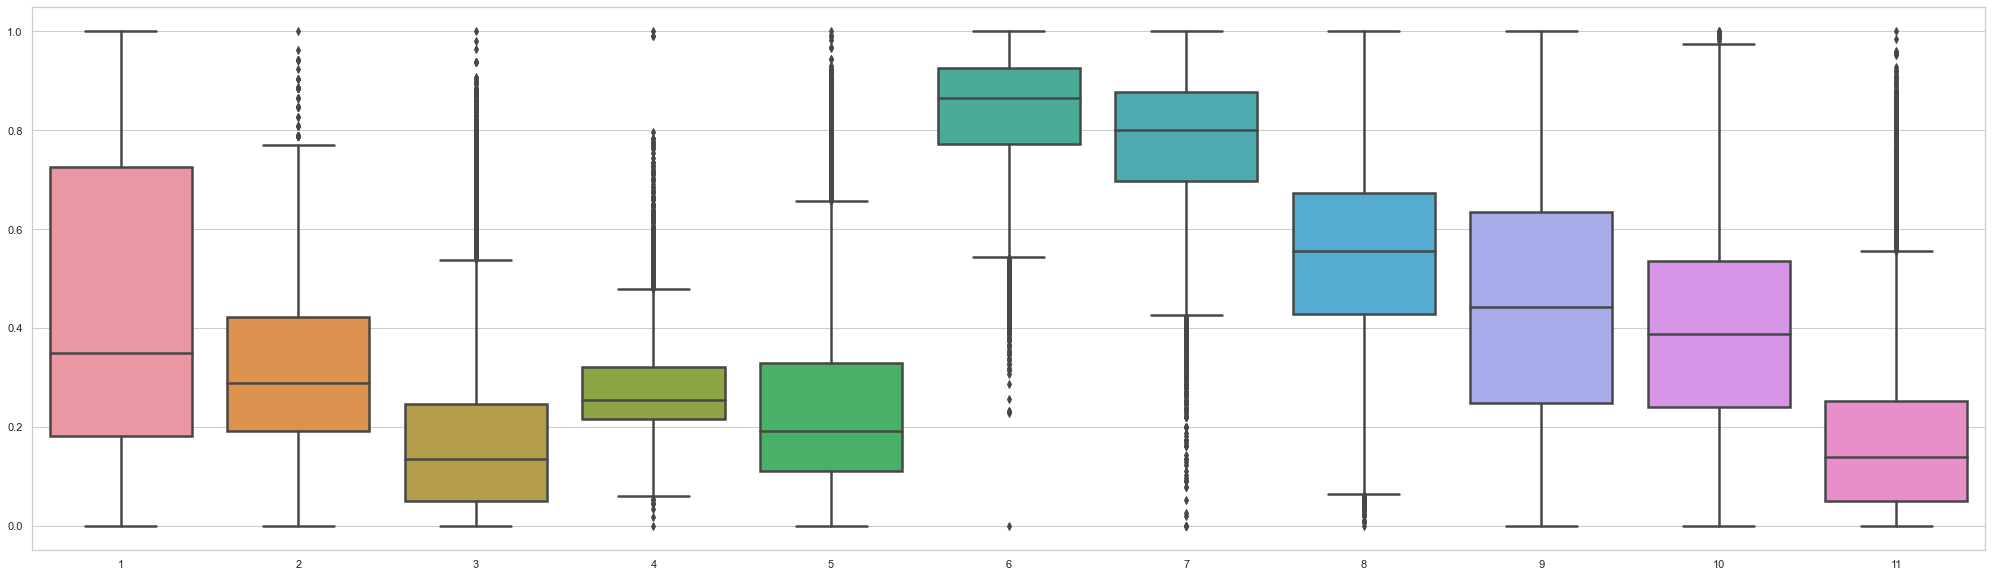

In [38]:
fig, axes = plt.subplots(1, figsize=(35, 10))
sns.set(style='whitegrid')
sns.boxplot(data=pd.DataFrame(data = train_scaled).iloc[:,1:12],linewidth=2.5)

---
### 5.3 Applying PowerTransformer 

In [39]:
pt = PowerTransformer()
train_pt = pt.fit_transform(train_scaled)

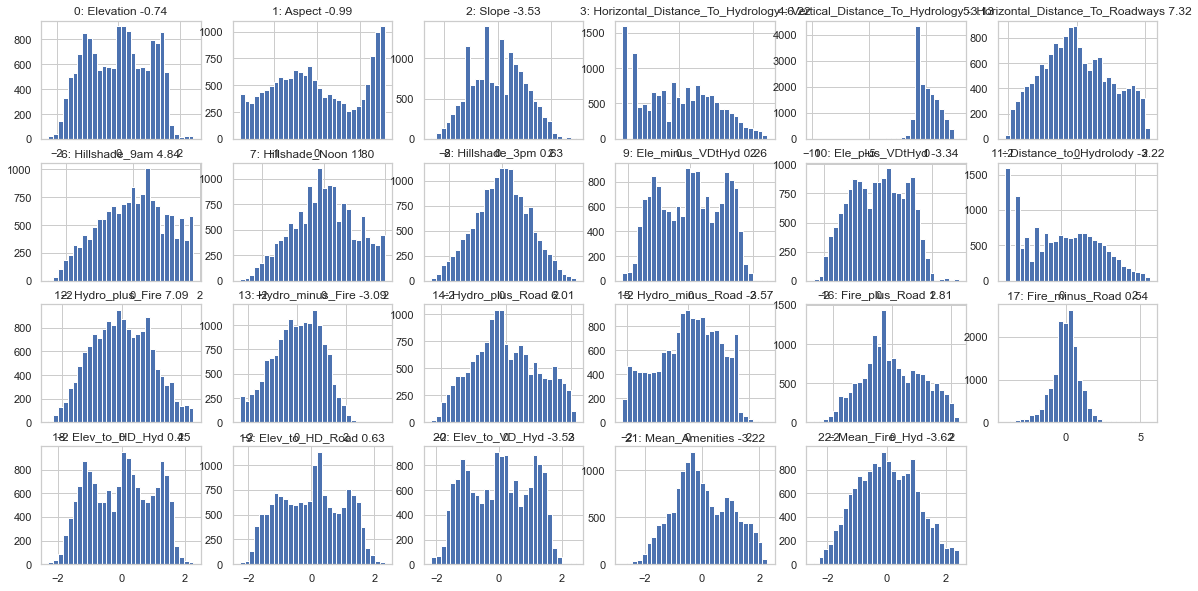

In [40]:
fig, axes = plt.subplots(4, 6, figsize=(20, 10))

for i, ax in enumerate(axes.ravel()):
    if i > 22:
        ax.set_visible(False)
        continue
    ax.hist(train_pt[:, i], bins=30)
    ax.set_title("{}: {} {:.2f}".format(i, train.columns[i+1], pt.lambdas_[i+1]))

<AxesSubplot:>

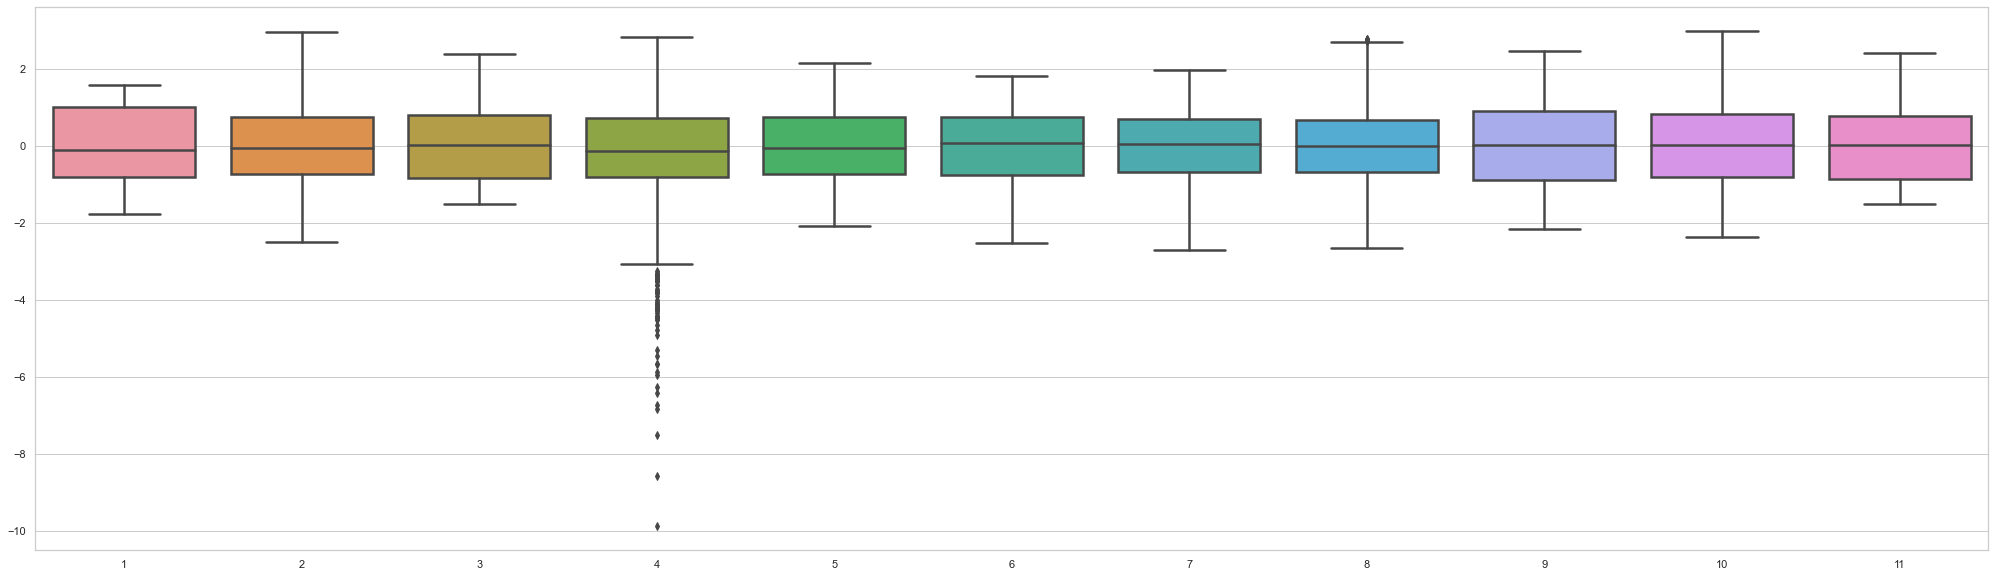

In [41]:
fig, axes = plt.subplots(1, figsize=(35, 10))
sns.set(style='whitegrid')
sns.boxplot(data=pd.DataFrame(data = train_pt).iloc[:,1:12],linewidth=2.5)

In [42]:
#train_pt = pd.DataFrame(data = train_pt, columns = train.iloc[:,1:62].keys())
#train_pt.head()

---
## 6. ML Predictive Analytics

---
### 6.1 Model setup

In [43]:
train.drop(['Id'], axis=1, inplace=True)
y = train.iloc[:, -1]
train = train.iloc[:, :-1]
test_Id = test.iloc[:, 0]
test.drop(['Id'], axis=1, inplace=True)

Drop columns?

In [44]:
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size = 0.1, shuffle= True)

---
### 6.2 Pipeline setup

In [45]:
sklearn.set_config(display="diagram")

In [46]:
numerical_pipeline = make_pipeline(
    RobustScaler(),
    PowerTransformer(), 
)

In [47]:
dirt_features = [col for col in train.columns if 'Soil' in col or "Wilderness" in col]

In [48]:
eng_features = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
                'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', "Ele_minus_VDtHyd", "Ele_plus_VDtHyd",
                "Distance_to_Hydrolody","Hydro_plus_Fire", "Hydro_minus_Fire", "Hydro_plus_Road", "Hydro_minus_Road", "Fire_plus_Road", "Fire_minus_Road",
                "Elev_to_HD_Hyd", "Elev_to_HD_Road", "Elev_to_VD_Hyd", "Mean_Amenities", "Mean_Fire_Hyd"]

ct = ColumnTransformer([
    ('scaler', numerical_pipeline,['Elevation', 
                                   'Aspect', 
                                   'Slope', 
                                   'Horizontal_Distance_To_Hydrology',
                                   'Vertical_Distance_To_Hydrology', 
                                   'Horizontal_Distance_To_Roadways',
                                   'Hillshade_9am',
                                   'Hillshade_Noon',
                                   'Hillshade_3pm',
                                   'Horizontal_Distance_To_Fire_Points',
                                   "Ele_minus_VDtHyd", "Ele_plus_VDtHyd",
                                   "Distance_to_Hydrolody","Hydro_plus_Fire",
                                   "Hydro_minus_Fire",
                                   "Hydro_plus_Road",
                                   "Hydro_minus_Road",
                                   "Fire_plus_Road",
                                   "Fire_minus_Road"]),
    ('pass_num','passthrough', dirt)
])

In [49]:
ct = ColumnTransformer([
    ('scaler', numerical_pipeline, eng_features),
    ('pass_num','passthrough', dirt_features)
])

In [50]:
clf = Pipeline([
    ("preprocessing", ct),
    ("classifier", ExtraTreesClassifier(n_estimators=400))
])
clf

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('scaler',
                                                  Pipeline(steps=[('robustscaler',
                                                                   RobustScaler()),
                                                                  ('powertransformer',
                                                                   PowerTransformer())]),
                                                  ['Elevation', 'Aspect',
                                                   'Slope',
                                                   'Horizontal_Distance_To_Hydrology',
                                                   'Vertical_Distance_To_Hydrology',
                                                   'Horizontal_Distance_To_Roadways',
                                                   'Hillshade_9am',
                                                   'Hillshade_Noon',
                                                   'Hillshade_3pm',
                                                   'Hor...
                                                   'Soil_Type5', 'Soil_Type6',
                                                   'Soil_Type7', 'Soil_Type8',
                                                   'Soil_Type9', 'Soil_Type10',
                                                   'Soil_Type11', 'Soil_Type12',
                                                   'Soil_Type13', 'Soil_Type14',
                                                   'Soil_Type15', 'Soil_Type16',
                                                   'Soil_Type17', 'Soil_Type18',
                                                   'Soil_Type19', 'Soil_Type20',
                                                   'Soil_Type21', 'Soil_Type22',
                                                   'Soil_Type23', 'Soil_Type24',
                                                   'Soil_Type25', 'Soil_Type26', ...])])),
                ('classifier', ExtraTreesClassifier(n_estimators=400))])

In [51]:
# clf = make_pipeline(ct, ExtraTreesClassifier(n_estimators=400))

---
### 6.3 PCA

In [52]:
from sklearn.decomposition import PCA

pca_forest = PCA()

principalComponents_forest = pca_forest.fit_transform(train_scaled[:,1:62])

pd.DataFrame(principalComponents_forest).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
count,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04
mean,-7.634068e-17,-2.409155e-17,7.965042e-17,5.877408e-17,2.123522e-17,2.234397e-17,2.949581e-17,-2.626867e-17,1.925497e-17,1.178694e-17,-6.093377e-17,-1.913336e-17,1.461206e-18,-4.300279e-17,4.930653e-18,4.005467e-18,-3.537367e-18,-1.588603e-17,-1.557350e-18,4.815464e-18,-2.307274e-17,1.728299e-18,3.720110e-17,1.006966e-17,1.039343e-17,1.228074e-17,4.549881e-18,2.451559e-18,2.727256e-18,1.228762e-17,-1.112105e-17,5.364977e-17,1.580939e-17,-1.892868e-17,-2.299381e-17,3.116077e-18,-1.053604e-17,1.032129e-17,-2.085569e-18,7.501417e-17,-6.284300e-17,3.499392e-17,-1.313089e-18,3.406725e-18,-2.433196e-17,-2.304959e-16,-5.335893e-17,1.906149e-17,-3.754980e-18,1.463123e-17,-5.809962e-18,-3.723674e-18,-2.027347e-17,4.794534e-18,-3.145021e-18,-4.233926e-18,3.493246e-18,-4.041359e-19,6.847034e-18,1.728087e-19
std,7.835154e-01,6.081408e-01,3.803492e-01,3.369204e-01,3.109438e-01,2.957741e-01,2.561981e-01,2.532111e-01,2.470077e-01,2.307972e-01,2.247899e-01,2.118746e-01,2.096423e-01,2.019400e-01,1.907189e-01,1.849507e-01,1.804054e-01,1.700286e-01,1.629646e-01,1.562586e-01,1.503599e-01,1.427401e-01,1.386570e-01,1.359628e-01,1.277330e-01,1.171469e-01,1.123403e-01,1.034622e-01,1.029787e-01,8.921772e-02,8.740358e-02,7.256043e-02,6.304014e-02,6.109308e-02,5.864340e-02,5.500773e-02,3.559168e-02,3.208070e-02,3.093544e-02,2.529544e-02,2.502331e-02,2.373321e-02,8.122120e-03,8.114387e-03,2.538905e-03,2.606489e-16,1.178817e-16,1.173303e-16,1.035832e-16,8.430361e-17,6.395974e-17,5.091179e-17,4.477577e-17,4.891749e-17,4.905118e-17,4.896920e-17,4.902761e-17,4.915025e-17,3.278035e-17,9.067881e-18
min,-1.479230e+00,-8.275288e-01,-8.537445e-01,-6.458621e-01,-1.077281e+00,-7.787287e-01,-9.294061e-01,-1.063207e+00,-6.556751e-01,-9.602066e-01,-5.106164e-01,-8.002861e-01,-5.727744e-01,-5.869324e-01,-6.353179e-01,-6.194864e-01,-4.805495e-01,-3.255632e-01,-5.309450e-01,-5.642677e-01,-7.020851e-01,-4.150216e-01,-5.002778e-01,-6.012668e-01,-4.538426e-01,-5.155361e-01,-4.261895e-01,-7.465208e-01,-4.739351e-01,-6.729686e-01,-2.569252e-01,-2.332068e-01,-4.755227e-01,-1.874258e-01,-6.408275e-01,-1.293481e-01,-1.230056e-01,-3.832439e-01,-1.554834e-01,-3.308444e-01,-2.306790e-01,-4.186998e-02,-6.088602e-01,-3.385285e-03,-6.398866e-03,-1.182434e-14,-2.613248e-15,-1.565181e-15,-2.998350e-15,-3.486092e-15,-1.253282e-15,-1.987980e-15,-4.398250e-16,-1.882747e-15,-1.235730e-15,-9.225084e-16,-5.685102e-16,-3.613805e-16,-1.081009e-15,-1.955443e-16
25%,-6.241304e-01,-6.064143e-01,-2.845505e-01,-2.288264e-01,-2.241706e-01,-1.935035e-01,-1.251188e-01,-1.548870e-01,-1.657106e-01,-1.148976e-01,-1.191188e-01,-7.763341e-02,-9.305561e-02,-7.383733e-02,-6.908625e-02,-1.079906e-01,-1.088585e-01,-7.254000e-02,-9.841254e-02,-5.601666e-02,-8.006665e-02,-1.050643e-01,-7.450260e-02,-5.090027e-02,-7.012153e-02,-6.466312e-02,-5.680549e-02,-1.869620e-02,-3.067849e-02,-2.231437e-02,-2.505995e-02,-4.579997e-02,-2.977478e-02,-2.628751e-02,-1.300706e-02,-9.232160e-03,-2.014586e-02,-5.200764e-03,-6.423689e-03,-4.923701e-03,-4.823970e-03,-6.144345e-03,-2.419324e-

Text(0.8, 0.97, '95% confidence threshold')

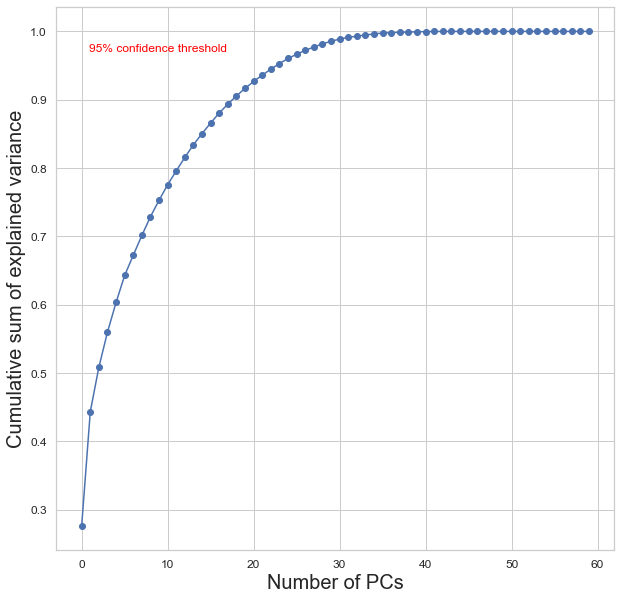

In [53]:
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.plot(np.cumsum(pca_forest.explained_variance_ratio_), '-o')
plt.xlabel('Number of PCs', fontsize=20)
plt.ylabel('Cumulative sum of explained variance' , fontsize=20);
plt.axhline(y=0.95, color='red', linestyle='', linewidth=3)
plt.text(0.80, 0.97, '95% confidence threshold',color='red', fontsize = 12)

In [54]:
clf = Pipeline([
    ("preprocessing", ct),
    ("pca", PCA(n_components = 25)),
    ("classifier", ExtraTreesClassifier()),
])
clf

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('scaler',
                                                  Pipeline(steps=[('robustscaler',
                                                                   RobustScaler()),
                                                                  ('powertransformer',
                                                                   PowerTransformer())]),
                                                  ['Elevation', 'Aspect',
                                                   'Slope',
                                                   'Horizontal_Distance_To_Hydrology',
                                                   'Vertical_Distance_To_Hydrology',
                                                   'Horizontal_Distance_To_Roadways',
                                                   'Hillshade_9am',
                                                   'Hillshade_Noon',
                                                   'Hillshade_3pm',
                                                   'Hor...
                                                   'Soil_Type7', 'Soil_Type8',
                                                   'Soil_Type9', 'Soil_Type10',
                                                   'Soil_Type11', 'Soil_Type12',
                                                   'Soil_Type13', 'Soil_Type14',
                                                   'Soil_Type15', 'Soil_Type16',
                                                   'Soil_Type17', 'Soil_Type18',
                                                   'Soil_Type19', 'Soil_Type20',
                                                   'Soil_Type21', 'Soil_Type22',
                                                   'Soil_Type23', 'Soil_Type24',
                                                   'Soil_Type25', 'Soil_Type26', ...])])),
                ('pca', PCA(n_components=25)),
                ('classifier', ExtraTreesClassifier())])

In [55]:
clf.set_params(**{"pca": None})

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('scaler',
                                                  Pipeline(steps=[('robustscaler',
                                                                   RobustScaler()),
                                                                  ('powertransformer',
                                                                   PowerTransformer())]),
                                                  ['Elevation', 'Aspect',
                                                   'Slope',
                                                   'Horizontal_Distance_To_Hydrology',
                                                   'Vertical_Distance_To_Hydrology',
                                                   'Horizontal_Distance_To_Roadways',
                                                   'Hillshade_9am',
                                                   'Hillshade_Noon',
                                                   'Hillshade_3pm',
                                                   'Hor...
                                                   'Soil_Type5', 'Soil_Type6',
                                                   'Soil_Type7', 'Soil_Type8',
                                                   'Soil_Type9', 'Soil_Type10',
                                                   'Soil_Type11', 'Soil_Type12',
                                                   'Soil_Type13', 'Soil_Type14',
                                                   'Soil_Type15', 'Soil_Type16',
                                                   'Soil_Type17', 'Soil_Type18',
                                                   'Soil_Type19', 'Soil_Type20',
                                                   'Soil_Type21', 'Soil_Type22',
                                                   'Soil_Type23', 'Soil_Type24',
                                                   'Soil_Type25', 'Soil_Type26', ...])])),
                ('pca', None), ('classifier', ExtraTreesClassifier())])

---
### 6.4 Grid Search

In [56]:
clf.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessing', 'pca', 'classifier', 'preprocessing__n_jobs', 'preprocessing__remainder', 'preprocessing__sparse_threshold', 'preprocessing__transformer_weights', 'preprocessing__transformers', 'preprocessing__verbose', 'preprocessing__scaler', 'preprocessing__pass_num', 'preprocessing__scaler__memory', 'preprocessing__scaler__steps', 'preprocessing__scaler__verbose', 'preprocessing__scaler__robustscaler', 'preprocessing__scaler__powertransformer', 'preprocessing__scaler__robustscaler__copy', 'preprocessing__scaler__robustscaler__quantile_range', 'preprocessing__scaler__robustscaler__unit_variance', 'preprocessing__scaler__robustscaler__with_centering', 'preprocessing__scaler__robustscaler__with_scaling', 'preprocessing__scaler__powertransformer__copy', 'preprocessing__scaler__powertransformer__method', 'preprocessing__scaler__powertransformer__standardize', 'classifier__bootstrap', 'classifier__ccp_alpha', 'classifier__class_weight', 'classifi

#### 6.4.1 Testing impact of scaling/transforming on different models 

In [57]:
param_grid = [
{
        "classifier": [ExtraTreesClassifier()],
        "classifier__n_estimators": [386],
        "classifier__random_state": [seed],
}
]
param_grid

[{'classifier': [ExtraTreesClassifier()],
  'classifier__n_estimators': [386],
  'classifier__random_state': [49]}]

In [ ]:
param_grid = [
    {
        "classifier": [LogisticRegression()],
        "classifier__random_state": [seed],
        "preprocessing__scaler__robustscaler" : [StandardScaler(),MinMaxScaler(), RobustScaler(), "passthrough"],
        "preprocessing__scaler__powertransformer" : [PowerTransformer(), "passthrough"],
        "pca" : [PCA(n_components = 25), "passthrough"],
        
    },
    {
        "classifier": [DecisionTreeClassifier()], 
        "classifier__random_state": [seed],
        "preprocessing__scaler__robustscaler" : [StandardScaler(),MinMaxScaler(), RobustScaler(), "passthrough"],
        "preprocessing__scaler__powertransformer" : [PowerTransformer(), "passthrough"],
        "pca" : [PCA(n_components = 25), "passthrough"],
    },
    {
        "classifier": [RandomForestClassifier()],
        "classifier__random_state": [seed],
        "preprocessing__scaler__robustscaler" : [StandardScaler(),MinMaxScaler(), RobustScaler(), "passthrough"],
        "preprocessing__scaler__powertransformer" : [PowerTransformer(), "passthrough"],
        "pca" : [PCA(n_components = 25), "passthrough"],
    },
    {
        "classifier": [ExtraTreesClassifier()],
        "classifier__random_state": [seed],
        "preprocessing__scaler__robustscaler" : [StandardScaler(),MinMaxScaler(), RobustScaler(), "passthrough"],
        "preprocessing__scaler__powertransformer" : [PowerTransformer(), "passthrough"],
        "pca" : [PCA(n_components = 25), "passthrough"],
    },
    {
        "classifier": [SVC()],
        "classifier__random_state": [seed],
        "preprocessing__scaler__robustscaler" : [StandardScaler(),MinMaxScaler(), RobustScaler(), "passthrough"],
        "preprocessing__scaler__powertransformer" : [PowerTransformer(), "passthrough"],
        "pca" : [PCA(n_components = 25), "passthrough"],
    },
    {
        "classifier": [AdaBoostClassifier()], 
        "classifier__random_state": [seed],
        "preprocessing__scaler__robustscaler" : [StandardScaler(),MinMaxScaler(), RobustScaler(), "passthrough"],
        "preprocessing__scaler__powertransformer" : [PowerTransformer(), "passthrough"],
        "pca" : [PCA(n_components = 25), "passthrough"],
    },
    {
        "classifier": [GradientBoostingClassifier()],
        "classifier__random_state": [seed],
        "preprocessing__scaler__robustscaler" : [StandardScaler(),MinMaxScaler(), RobustScaler(), "passthrough"],
        "preprocessing__scaler__powertransformer" : [PowerTransformer(), "passthrough"],
        "pca" : [PCA(n_components = 25), "passthrough"],
    }
]
param_grid

param_grid = [
    {
        "extratreesclassifier": [ExtraTreesClassifier()],
        "extratreesclassifier__n_estimators": [400],
        "extratreesclassifier__random_state": [seed],
    },
    {
        "extratreesclassifier": [DecisionTreeRegressor()], 
        "extratreesclassifier__random_state": [seed],
    },
    {
        "extratreesclassifier": [RandomForestRegressor()],
        "extratreesclassifier__random_state": [seed],
    }
]
param_grid

In [ ]:
gs = GridSearchCV(clf, param_grid=param_grid, n_jobs=-1, cv=5)
gs

In [ ]:
gs.fit(X_train, y_train)

In [ ]:
# results = pd.DataFrame(gs.cv_results_)
results = pd.DataFrame(gs.cv_results_).sort_values("rank_test_score")
results

#### 6.4.2 Testing hyperparameters for best performing model

In [ ]:
clf.get_params().keys()

In [77]:
param_grid = [
{
        "classifier": [ExtraTreesClassifier()],
        "classifier__max_depth": np.linspace(5, 20, num=15, dtype = int),
        "classifier__n_estimators": np.linspace(300, 450, num=150, dtype = int),
        "classifier__max_features": np.linspace(0.1, 1, num=10),
        "classifier__random_state": [seed],
}
]

In [78]:
gs = GridSearchCV(clf, param_grid=param_grid, n_jobs=-1, cv=5)
gs

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('scaler',
                                                                         Pipeline(steps=[('robustscaler',
                                                                                          RobustScaler()),
                                                                                         ('powertransformer',
                                                                                          PowerTransformer())]),
                                                                         ['Elevation',
                                                                          'Aspect',
                                                                          'Slope',
                                                                          'Horizontal_Distance_To_Hydrology',
                                                                          'Vertical_Distance_To_Hydrology',
                                                                          'Horizontal_Distance_To_Roadways',
                                                                          'Hillshade_9am',
                                                                          'Hillsha...
       419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431,
       432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444,
       445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457,
       458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470,
       471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483,
       484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496,
       497, 498, 500]),
                          'classifier__random_state': [49]}])

In [79]:
gs.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
results = pd.DataFrame(gs.cv_results_).sort_values("rank_test_score")
results

In [ ]:
gs.best_params_

---
### 6.5 Evaluation

In [ ]:
gs.best_score_

In [ ]:
gs.best_estimator_.score(X_test, y_test)

In [ ]:
model = ExtraTreesClassifier(n_estimators = 386, random_state = 49)

In [ ]:
y_hat = gs.predict(X_test)

In [ ]:
#Evaluating model with classification report and confusion matrix
class_report = classification_report(y_test, y_hat)
conf_matrix = confusion_matrix(y_test, y_hat)
acc_test = accuracy_score(y_test, y_hat)    # accuracy achieved on the test data

print(f"Best Model Report")       
print(f"Class Report: {class_report}")    

cm = confusion_matrix(y_test, y_hat)    
cm_df = pd.DataFrame(cm,
                     index = [0,1,2,3,4,5,6],
                     columns = [0,1,2,3,4,5,6])
plt.figure(figsize=(8,8))
sns.heatmap(cm_df, annot=True)
plt.title(f"Confusion Matrix", 
          size = 20, 
          pad = 15)
plt.ylabel("Observed", size = 18, labelpad = 13)
plt.xlabel("Predicted", size = 18, labelpad = 13)
plt.show()

---
### 6.6 Prediction

In [ ]:
test_predictions = gs.predict(test)

In [ ]:
solutions = pd.DataFrame({'Id': test_Id, 'Cover_Type': test_predictions})
solutions.to_csv('finsubmission_7.csv',index=False)

---
## 7. Findings

[...]

https://www.kaggle.com/code/kickitlikeshika/extra-trees-79-accuracy
https://shankarmsy.github.io/posts/forest-cover-types.html
https://www.kaggle.com/code/sharmasanthosh/exploratory-study-on-feature-selection